<a href="https://colab.research.google.com/github/dadecampo/CVDeepLearning/blob/main/wGrapesFasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from albumentations.core.composition import Compose
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
from albumentations.augmentations.geometric.transforms import HorizontalFlip
from albumentations.augmentations.geometric.rotate import Rotate
from albumentations.augmentations.crops.transforms import BBoxSafeRandomCrop
from albumentations.augmentations.transforms import HueSaturationValue
from albumentations.augmentations.transforms import ColorJitter, RandomBrightnessContrast

from albumentations.augmentations.geometric.resize import Resize
from albumentations.augmentations.geometric import Affine

from albumentations.augmentations.geometric.resize import RandomScale
import albumentations as A
import random

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)
BATCH_SIZE = 1
EPOCHS = 5
IMAGE_WIDTH = 1216
IMAGE_HEIGHT = 1216
FILES_DIR_WGISD = "dataset/wgisd/"
FILES_DIR_WGRAPE = "dataset/Calibrated_Images/"


def get_transform(train):
  if train:
    return Compose(
      [
        HorizontalFlip(p=0.5),
        RandomScale(scale_limit=0.4, interpolation = cv2.INTER_LINEAR, p=0.5),
        BBoxSafeRandomCrop(p=0.5),
        ColorJitter(random.uniform(0,0.2), random.uniform(0,0.2), random.uniform(0,0.2), random.uniform(0,0.2), p=0.5),
        ToTensorV2(p = 1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return Compose(
      [
        ToTensorV2(p=1.0)
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )


cuda


In [56]:

class GrapeDataset(torch.utils.data.Dataset):
    def __init__(self, root, width, height, transforms = None):
        self.transforms = transforms
        self.root = root
        self.no_size=False
        self.width =0
        self.height=0
        if(width==0 and height==0):
            self.no_size=True
        else:
            self.width = width
            self.height = height

        self.imgs=[]
        boxes_files=[]
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if file.endswith(".txt") and not file.startswith("_counting"):
                    boxes_files.append(os.path.join(root, file))
                if file.endswith(".jpg") or file.endswith(".JPG") or file.endswith(".JPEG") or file.endswith(".jpeg"):
                    self.imgs.append(os.path.join(root, file))
                if file.startswith("_counting"):
                   self.conting_file = os.path.join(root, "_counting.txt")
        self.imgs = sorted(self.imgs)
        boxes_files = sorted(boxes_files)
        self.boxes = boxes_files

    def __getitem__(self, idx):
        # get image and boxes
        img_path = self.imgs[idx]
        box_path = self.boxes[idx]
        # image elaboration
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        if not self.no_size:
            img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0

        height, width, _ = img.shape
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        labels=[]
        boxes=[]
        with open(box_path) as f:
            for line in f:
                labels.append(1)

                elems=[float(x) for x in line.split(' ')]

                x_center = int(elems[1] * width)
                y_center = int(elems[2] * height)
                box_wt = int(elems[3] * width)
                box_ht = int(elems[4] * height)

                x_min = max(0.0, x_center - box_wt/2)
                x_max  = min(width, x_center + box_wt/2)
                y_min = max(0.0, y_center - box_ht/2)
                y_max  = min(height, y_center + box_ht/2)

                boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels= torch.as_tensor(labels, dtype=torch.int64)
        iscrowd= torch.zeros((boxes.shape[0],),dtype=torch.int64)
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        target={}
        target["boxes"] = boxes
        target["area"] = area
        target["labels"]= labels
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img,
                                bboxes = target['boxes'],
                                labels = labels)
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img, target

    def __len__(self):
        return len(self.imgs)



Number of Dataset Images:  300


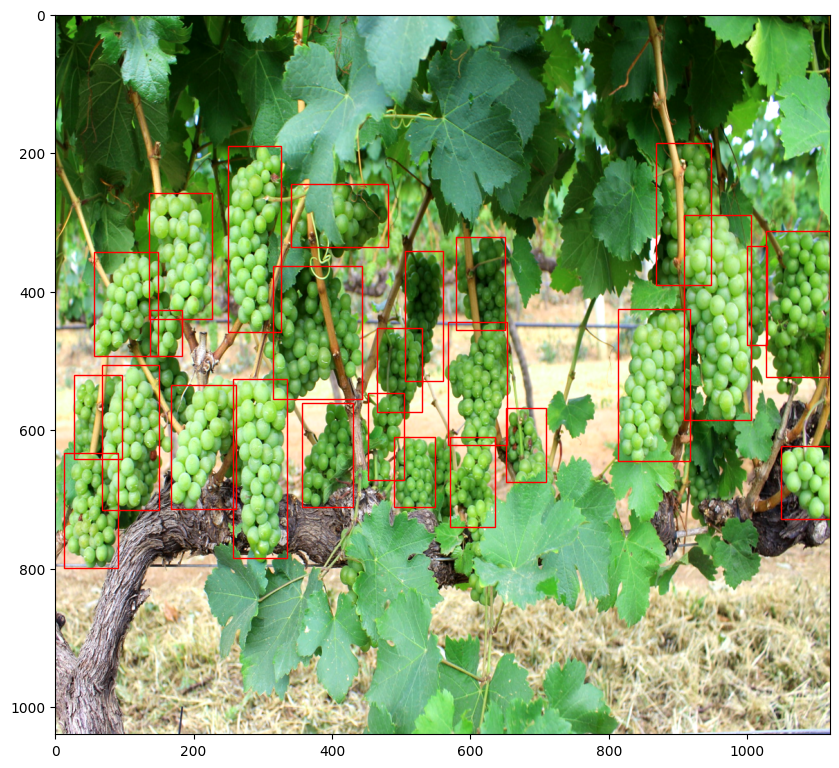

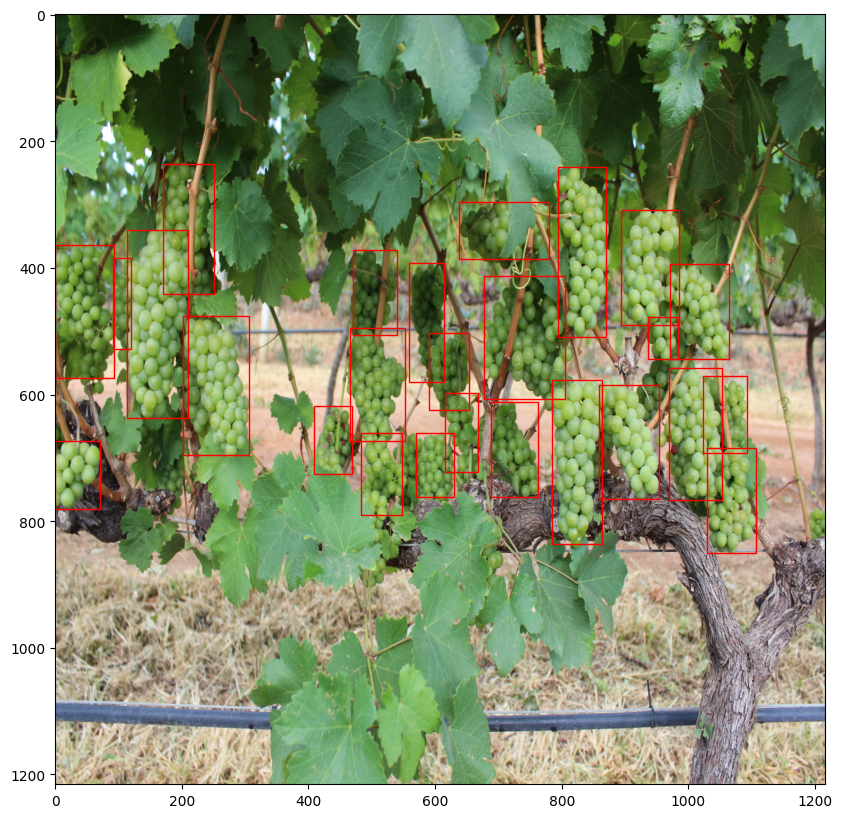

In [57]:
    
def plot_img_bbox(img, target, prediction):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, ax = plt.subplots(1,1)
  fig.set_size_inches(10,10)
  img=img.permute(1,2,0)
  ax.imshow(img)

  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'black',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax.add_patch(rect)

  for box in (prediction['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 1,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax.add_patch(rect)
  plt.show()

    
def plot_img_bbox_alone(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, ax = plt.subplots(1,1)
  fig.set_size_inches(10,10)
  img=img.permute(1,2,0)
  ax.imshow(img)

  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 1,
      edgecolor = 'red',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax.add_patch(rect)

  plt.show()
    


dataset_train = GrapeDataset(FILES_DIR_WGISD, IMAGE_WIDTH, IMAGE_HEIGHT,  transforms=get_transform(train=True))
dataset_test = GrapeDataset(FILES_DIR_WGISD, IMAGE_WIDTH, IMAGE_HEIGHT,  transforms=get_transform(train=False))
print("Number of Dataset Images: ", len(dataset_test))
n = random.randint(0,len(dataset_test)-1)
img, target = dataset_train[n]
plot_img_bbox_alone(img, target)
img, target = dataset_test[n]
plot_img_bbox_alone(img, target)

In [58]:
from tqdm.notebook import tqdm 
import time
import torch
import numpy

loss_objectness = []
loss_box_reg = []
loss_classifier= []

def train_epoch(model, optimizer, data_loader, device, epoch):
        model.train()

        for i, (images, targets) in (tepoch := tqdm(enumerate(data_loader), unit="batch", total=len(data_loader))):
            tepoch.set_description(f"Epoch {epoch}")
            if len(targets)==0:
                  continue
            # Step 1: send the image to the required device.
            # Images is a list of B images (where B = batch_size of the DataLoader).
            images = list(img.to(device) for img in images)
            # Step 2: send each target to the required device
            # Targets is a dictionary of metadata. each (k,v) pair is a metadata
            # required for training.
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model_time = time.time()
            loss_dict=model(images, targets)
            
            model_time = time.time() - model_time
            loss_objectness.append(loss_dict["loss_objectness"].cpu().detach().numpy())
            loss_box_reg.append(loss_dict["loss_box_reg"].cpu().detach().numpy())
            loss_classifier.append(loss_dict["loss_classifier"].cpu().detach().numpy())
            # Step 3. backward on loss.
            # Normally, you would obtain the loss from the model.forward()
            # and then just call .bacward() on it.
            # In this case, for each task, you have a different loss, due to
            # different error metrics adopted by the tasks.
            # One typical approach is to combine all the losses to one single loss,
            # and then then backward that single loss.
            # In this way you can adjust the weight of the different tasks,
            # multiplying each loss for a hyperparemeter.
            # E.G.:
            #       final_loss = loss_1 + gamma*(alpha*loss_2 + beta*loss_3)
            # In this case, we want to sum up all the losses.
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            tepoch.set_postfix(loss=losses.item())


In [59]:
from detection.utils import collate_fn
import detection.transforms as T
# use our dataset and defined transformations
def redefine_dataset(path, size_image_width, size_image_height):
    dataset = GrapeDataset(path, size_image_width, size_image_height, transforms=get_transform(train=True))
    dataset_test = GrapeDataset(path, size_image_width, size_image_height,  transforms=get_transform(train=False))

    # train test split
    torch.manual_seed(random.randint(0,100))
    indices = torch.randperm(len(dataset)).tolist()
    test_split = 0.2
    print(len(dataset))
    tsize = int(len(dataset)*test_split)
    dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
    print(len(dataset))
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])
    print(len(dataset_test))
    
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn,
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn,
    )

    return data_loader, data_loader_test


data_loader_wgisd, data_loader_test_wgisd = redefine_dataset(FILES_DIR_WGISD, IMAGE_WIDTH, IMAGE_HEIGHT)
print(str(len(data_loader_wgisd))+" "+str(len(data_loader_test_wgisd)))
data_loader_wgrape, data_loader_test_wgrape = redefine_dataset(FILES_DIR_WGRAPE, IMAGE_WIDTH, IMAGE_HEIGHT)
print(str(len(data_loader_wgrape))+" "+str(len(data_loader_test_wgrape)))




300
240
60
240 60
269
216
53
216 53


In [60]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNConvFCHead
from torchvision.models.detection.faster_rcnn import RPNHead
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def create_model(num_classes, backbone="resnet_50"):

    model=None
    if backbone == "mobilenet":
        vgg_net = torchvision.models.mobilenet_v2(pretrained=True)
        ft_backbone = vgg_net.features
        ft_backbone.out_channels = 1280
        anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
        )
        # Feature maps to perform RoI cropping.
        # If backbone returns a Tensor, `featmap_names` is expected to
        # be [0]. We can choose which feature maps to use.
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        # Final Faster RCNN model.
        model = FasterRCNN(
            backbone=ft_backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )
    elif backbone == "vgg16":
        vgg_net = torchvision.models.vgg16_bn(pretrained=True)
        ft_backbone = vgg_net.features
        ft_backbone.out_channels = 512
        anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
        )
        # Feature maps to perform RoI cropping.
        # If backbone returns a Tensor, `featmap_names` is expected to
        # be [0]. We can choose which feature maps to use.
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        # Final Faster RCNN model.
        model = FasterRCNN(
            backbone=ft_backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )

    elif backbone == "vgg19":
        vgg_net = torchvision.models.vgg19_bn(pretrained=True)
        ft_backbone = vgg_net.features
        ft_backbone.out_channels = 512
        anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
        )
        # Feature maps to perform RoI cropping.
        # If backbone returns a Tensor, `featmap_names` is expected to
        # be [0]. We can choose which feature maps to use.
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        # Final Faster RCNN model.
        model = FasterRCNN(
            backbone=ft_backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )
    elif backbone == "resnet18_fpn":
        backbone = resnet_fpn_backbone('resnet18', True)
        model = FasterRCNN(backbone, num_classes)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    elif backbone == "resnet50_fpn":
        backbone = resnet_fpn_backbone('resnet50', True)
        model = FasterRCNN(backbone, num_classes)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    elif backbone == "resnet101_fpn":
        backbone = resnet_fpn_backbone('resnet101', True)
        model = FasterRCNN(backbone, num_classes)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
    else:
        print("Error Wrong unsupported Backbone")
        return

    return model
    

In [61]:
import random
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torchvision import transforms as torchtrans
from detection.engine import train_one_epoch, evaluate
import detection.utils
import detection.transforms as T
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet, RetinaNet_ResNet50_FPN_V2_Weights, FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models import ResNet50_Weights, resnet101
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, RetinaNetRegressionHead
from functools import partial
from tqdm.notebook import tqdm 
import gc

# train on gpu if available

num_classes = 2 # one class (class 0) is dedicated to the "background"
backbones=["mobilenet","vgg16","vgg19","resnet18_fpn", "resnet50_fpn", "resnet101_fpn"]
# backbones=["resnet50_fpn"]
coco_tests = []
fps_tests = []


lr=0.005
coco = None
metric_logger=[]
for backbone in backbones:
    # get the model using our helper function
    model = create_model(num_classes, backbone=backbone)
    # model = torch.load("weights/wgisd_frcnn.pth")
    
    # move model to the right device
    model.to(DEVICE)

    params = [p for p in model.parameters() if p.requires_grad]
    print(len(params))

    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=lr*0.1)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        gamma=0.1,
        step_size=2
    )
    for epoch in range(EPOCHS):
        gc.collect()
        torch.cuda.empty_cache()
        # training for one epoch
        train_one_epoch(model, optimizer, data_loader_wgisd, DEVICE, epoch, 10)
        lr_scheduler.step()
        coco = evaluate(model, data_loader_test_wgisd, device=DEVICE)
        # evaluate on the test dataset

    #evaluate fps
    img, target = dataset_test[0]
    # put the model in evaluation mode
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        prediction = model([img.to(DEVICE)])[0]
    # get the end time
    end_time = time.time()
    # get the fps
    fps = 1 / (end_time - start_time)
    print(fps)
    
    fps_tests.append(fps)
    coco_tests.append(coco)


In [ ]:
coco = evaluate(model, data_loader_test_wgisd, device=DEVICE)

creating index...
index created!
Test:  [ 0/60]  eta: 0:00:17  model_time: 0.2470 (0.2470)  evaluator_time: 0.0090 (0.0090)  time: 0.2960  data: 0.0347  max mem: 2790
Test:  [59/60]  eta: 0:00:00  model_time: 0.0374 (0.0415)  evaluator_time: 0.0111 (0.0107)  time: 0.0912  data: 0.0403  max mem: 2790
Test: Total time: 0:00:05 (0.0936 s / it)
Averaged stats: model_time: 0.0374 (0.0415)  evaluator_time: 0.0111 (0.0107)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.785
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.455
 Average Recall     (AR) @[ IoU=

In [ ]:
torch.save(model, "weights/frcnn.pth")

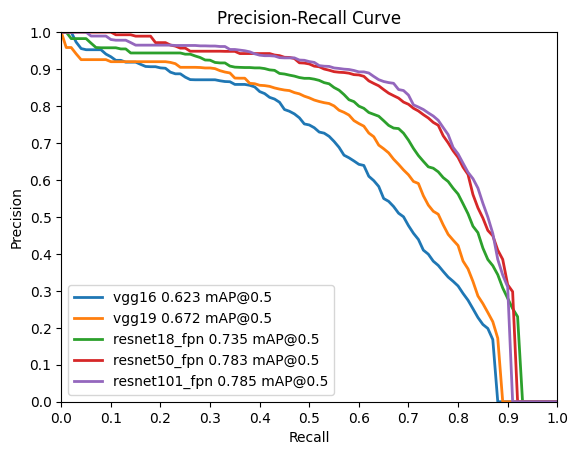

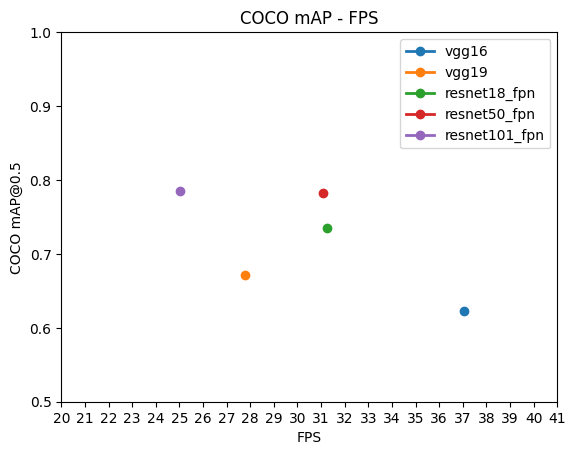

In [ ]:
#F1 = (2 * precision * recall)/(precision+recall)
for i in range(0,len(backbones)):
    all_precision = coco_tests[i].coco_eval['bbox'].eval['precision']
    map = coco_tests[i].coco_eval['bbox'].stats[1]

    pr_5 = all_precision[0, :, 0, 0, 2] # data for IoU@0.5
    x = np.arange(0, 1.01, 0.01)
    plt.plot(x, pr_5, label=backbones[i]+str(" {:.3f} mAP@0.5".format(map)), linewidth=2)


plt.legend(loc="best")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xticks(np.arange(0, 1.0001, 0.1))
plt.yticks(np.arange(0, 1.0001, 0.1))

plt.show()

#F1 = (2 * precision * recall)/(precision+recall)
for i in range(0,len(backbones)):
    all_precision = coco_tests[i].coco_eval['bbox'].eval['precision']
    map = coco_tests[i].coco_eval['bbox'].stats[1]
    plt.plot(fps_tests[i], map, label=backbones[i], linewidth=2, marker='o')

plt.legend(loc="best")
plt.xlim(min(fps_tests)-0.1, max(fps_tests))
plt.ylim(0.5, 1)
plt.title('COCO mAP - FPS')
plt.xlabel('FPS')
plt.ylabel('COCO mAP@0.5')
plt.xticks(np.arange(int(min(fps_tests)-5), int(max(fps_tests)+5), 1))
plt.yticks(np.arange(0.5, 1.0001, 0.1))

plt.show()

# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'].cpu(), orig_prediction['scores'].cpu(), iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'].cpu()[keep]
    final_prediction['scores'] = final_prediction['scores'].cpu()[keep]
    final_prediction['labels'] = final_prediction['labels'].cpu()[keep]
    
    return final_prediction

24.90886415735275
MODEL OUTPUT



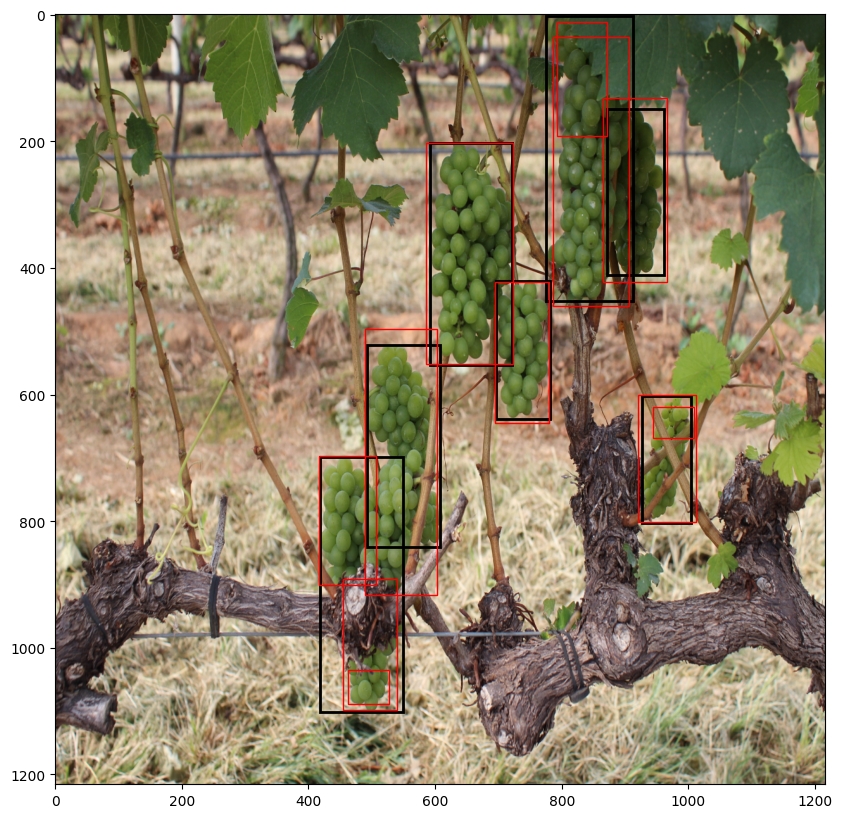

In [ ]:
img, target = dataset_test[1]
# put the model in evaluation mode
model.eval()
start_time = time.time()

with torch.no_grad():
    prediction = model([img.to(DEVICE)])[0]
# get the end time
end_time = time.time()
# get the fps
fps = 1 / (end_time - start_time)
print(fps)

print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.3)

plot_img_bbox(img, target, nms_prediction)